In [1]:
import glob

# Data manipulation
import numpy as np
import pandas as pd

# Statistics
from scipy.stats import mannwhitneyu, fisher_exact

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['svg.fonttype'] = 'none'

### Plot depicting distribution of gene vs species distance in transfers/no transfers

In [2]:
min_node_support = 0.5
min_seq_coverage = 50

In [3]:
pairs_w_transfers = pd.read_csv("gene_pairs_with_transfers_score_80_and_info_on_support_dist_and_seq_identity.tsv", sep = "\t")
print(pairs_w_transfers.shape)

# Removing rows that don't pass node support and sequence coverage filters.
pairs_w_transfers = pairs_w_transfers.loc[(pairs_w_transfers["min_support"] >= min_node_support) & (pairs_w_transfers["seq_coverage"] >= min_seq_coverage), :]
pairs_w_transfers["transfer"] = 1
pairs_w_transfers = pairs_w_transfers.loc[: ,["family_id", "node_id", "transfer", \
                                              "speci_1", "genome_1", "gene_1", \
                                              "speci_2", "genome_2", "gene_2", \
                                              "distance", "gene_distance", "seq_identity", "seq_coverage"] ]
print(pairs_w_transfers.shape)

/Users/mdmit/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(93468860, 18)
(15652838, 13)


In [4]:
pairs_wo_transfers = pd.read_csv("gene_pairs_without_transfers_info_on_dist_and_seq_identity.tsv", sep = "\t")
pairs_wo_transfers["node_id"] = "unknown"
pairs_wo_transfers["transfer"] = 0
pairs_wo_transfers = pairs_wo_transfers.loc[: , pairs_w_transfers.columns]
print(pairs_wo_transfers.shape)

# Removing rows that don't pass the sequence coverage filter.
pairs_wo_transfers = pairs_wo_transfers.loc[(pairs_wo_transfers["seq_coverage"] >= min_seq_coverage), :]
print(pairs_wo_transfers.shape)

(3048789, 13)
(3044441, 13)


In [5]:
# For each genome pair, retaining only one gene pair with the the highest sequence identity to compare.
selected_pairs = pd.concat([pairs_w_transfers, pairs_wo_transfers])
print(selected_pairs.shape)

# Filtering out pairs where one of the genomes or specI clusters is problematic to prevent transfer count inflation.
problematic_genomes = ["1932669.SAMEA43981918", "550.SAMEA3856670", "1916230.SAMN05904579", "1618951.SAMN03319549",
                       "1802238.SAMN04314631", "74031.SAMN03943304", "663.SAMN04088202"]
selected_pairs = selected_pairs.loc[~(selected_pairs["genome_1"].isin(problematic_genomes)) & ~(selected_pairs["genome_2"].isin(problematic_genomes)), :]
problematic_clusters = ["Cluster22", "Cluster2375", "Cluster4851", "Cluster5010", "Cluster5514"]
selected_pairs = selected_pairs.loc[~(selected_pairs["speci_1"].isin(problematic_clusters)) & ~(selected_pairs["speci_2"].isin(problematic_clusters)), :]
print(selected_pairs.shape)

selected_pairs = selected_pairs.sort_values("gene_distance", ascending = False).drop_duplicates(["family_id", "speci_1", "speci_2"])
print(selected_pairs.shape)

(18697279, 13)
(18653174, 13)
(18603920, 13)


In [6]:
# To standardize bins between pairs with and without transfers, we set limits to the phylogenetic distance
# and, sequence identity and gene distance.
min_distance = 0
max_distance = 1.2

min_gene_distance = 0
max_gene_distance = 0.8

min_identity = 60
max_identity = 100

bin_number = 80

distance_step = (max_distance - min_distance)/bin_number
gene_distance_step = (max_gene_distance - min_gene_distance)/bin_number
identity_step = (max_identity - min_identity)/bin_number

In [7]:
# Retaining only gene pairs within defined limits
selected_pairs = selected_pairs.loc[(selected_pairs["distance"] >= min_distance) & (selected_pairs["distance"] <= max_distance), :]
selected_pairs = selected_pairs.loc[(selected_pairs["gene_distance"] >= min_gene_distance) & (selected_pairs["gene_distance"] <= max_gene_distance), :]

# For plotting 2D histogram, we will need to multiply the number of pairs without transfers
# to match the number of pairs with transfers. Calculating the factor by which to multiply with.
n_pairs_w_transfers = len(selected_pairs.loc[selected_pairs["transfer"] == 1, :])
n_pairs_wo_transfers = len(selected_pairs.loc[selected_pairs["transfer"] == 0, :])
multiply_factor = n_pairs_w_transfers / n_pairs_wo_transfers

# For plotting marginal histograms with equal number of pairs with and without transfers,
# we subsample the transfers.
histogram_pairs = pd.concat([selected_pairs.loc[(selected_pairs["transfer"] == 0), :],
                             selected_pairs.loc[(selected_pairs["transfer"] == 1), :].iloc[np.random.choice(n_pairs_w_transfers, n_pairs_wo_transfers, replace = False), :]]) 

In [8]:
histogram_pairs = histogram_pairs.reset_index()
histogram_pairs.head()

index                                 family_id  node_id  transfer  \
0  1857543  1229172.SAMN02953965.GCA_000763385_03603  unknown         0   
1  2070173      1125719.SAMN00792203.HMPREF1319_1546  unknown         0   
2  1011163    68042.SAMD00021056.GCA_001553435_00720  unknown         0   
3   268375           1453352.SAMN03272543.SB49_13695  unknown         0   
4  1275592  1294260.SAMD00000530.GCA_001311985_04090  unknown         0   

       speci_1              genome_1               gene_1      speci_2  \
0  Cluster8581  1552121.SAMD00020894       NIES2104_15660  Cluster7258   
1  Cluster7447  1227266.SAMN02436819     HMPREF1551_02502  Cluster6313   
2  Cluster2766  1559982.SAMD00020875  GCA_001652895_07930  Cluster2763   
3  Cluster7872  1300341.SAMN03702328            I595_1244  Cluster4109   
4  Cluster4083   243231.SAMN02603989              GSU0115  Cluster3918   

               genome_2               gene_2  distance  gene_distance  \
0  1173264.SAMN02261357  GCA_000332095_04527    0.6231            0.8   
1    45243.SAMN04435862          AXF12_10635    0.4396            0.8   
2    67365.SAMN05366068  GCA_001704635_07448    0.1167            0.8   
3  1348585.SAMN02208950           M667_03095    0.4520            0.8   
4   316067.SAMN00623045            Geob_0443    0.4499            0.8   

   seq_identity  seq_coverage  
0         66.18         88.12  
1         67.18         96.13  
2         70.06         84.26  
3         68.10         96.50  
4         64.59         97.02

-6.282757322084939 6.119806586655703


/Users/mdmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


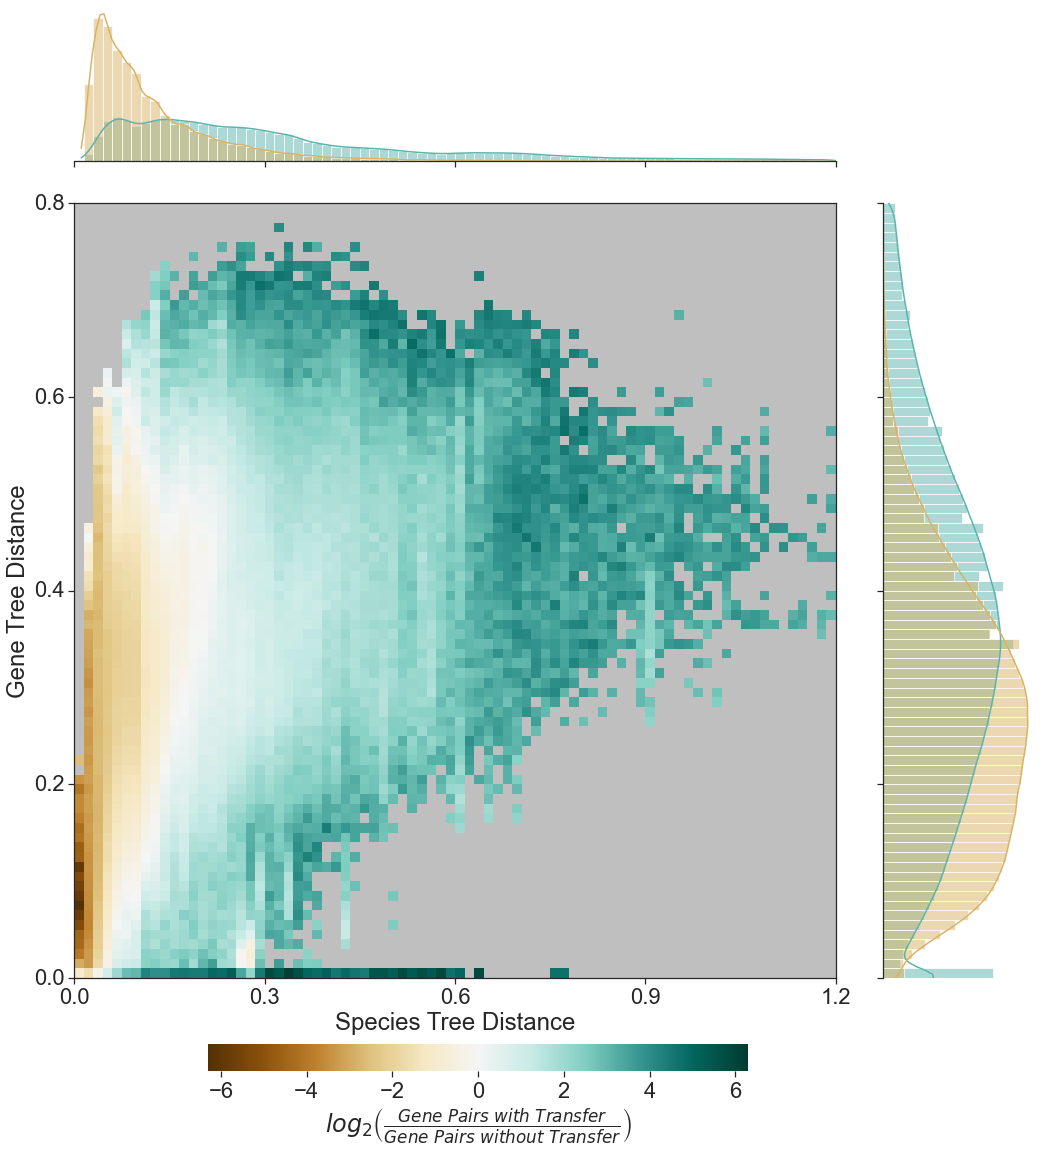

In [9]:
# For joint plot, need to calculate the ratio of pair counts between transfers and non-transfers.
histogram_w_transfers  = np.histogram2d(x = selected_pairs.loc[(selected_pairs["transfer"] == 1), "distance"],
                                        y = selected_pairs.loc[(selected_pairs["transfer"] == 1), "gene_distance"],
                                        bins = bin_number,
                                        range = [[min_distance, max_distance], [min_gene_distance, max_gene_distance]])
histogram_wo_transfers = np.histogram2d(x = selected_pairs.loc[(selected_pairs["transfer"] == 0), "distance"],
                                        y = selected_pairs.loc[(selected_pairs["transfer"] == 0), "gene_distance"],
                                        bins = bin_number,
                                        range = [[min_distance, max_distance], [min_gene_distance, max_gene_distance]])
histogram_w_transfers[0][histogram_w_transfers[0] < 10] = np.nan
histogram_wo_transfers[0][histogram_wo_transfers[0] < 10] = np.nan

ratio = np.log2(histogram_w_transfers[0] / (multiply_factor * histogram_wo_transfers[0]))
ratio = np.transpose(ratio)
print(np.nanmin(ratio), np.nanmax(ratio))

sns.set(font_scale = 2)
sns.set_style("ticks")
figures, axes = plt.subplots(2, 2, figsize = (15, 15),
                             gridspec_kw = {"width_ratios": [5, 1], "height_ratios": [1, 5]})
cbar_ax = figures.add_axes([0.21, -0.01, 0.5, .025])

with sns.axes_style("white"):
    sns.histplot(data = histogram_pairs, x = "distance", hue = "transfer", kde = True, legend = False,
                 alpha = 0.5, bins = bin_number, binrange = [min_distance, max_distance], ax = axes[0,0],
                 palette = ["#d8b365", "#5ab4ac"])


sns.heatmap(ratio, annot = False, cmap = "BrBG", ax = axes[1, 0], center = 0, cbar_ax = cbar_ax,
            vmin = -6.3, vmax = 6.3,
            cbar_kws={'label': r'$log_2\left(\frac{Gene\ Pairs\ with\ Transfer}{Gene\ Pairs\ without\ Transfer}\right)$', 'orientation': 'horizontal'})

with sns.axes_style("white"):
    sns.histplot(data = histogram_pairs, y = "gene_distance", hue = "transfer", kde = True, legend = False,
                 alpha = 0.5, bins = bin_number, binrange = [min_gene_distance, max_gene_distance], ax = axes[1,1],
                 palette = ["#d8b365", "#5ab4ac"])

axes[0,0].set(xlim = [min_distance, max_distance], xlabel = "", ylabel = "", yticks = [], yticklabels = [],
              xticks = np.array([0, 0.25*max_distance, 0.5*max_distance, 0.75*max_distance, max_distance]), xticklabels = [])
sns.despine(ax = axes[0,0], left = True, top = True, right = True, bottom = False)

axes[0,1].axis('off')

axes[1,0].invert_yaxis()
axes[1,0].set_xlabel("Species Tree Distance")
axes[1,0].set_xticks(np.array([0, 0.25*bin_number, 0.5*bin_number, 0.75*bin_number, bin_number]))
axes[1,0].set_xticklabels(["{:.1f}".format(x) for x in [0, 0.25*max_distance, 0.5*max_distance, 0.75*max_distance, max_distance]], rotation = 0)
axes[1,0].set_ylabel("Gene Tree Distance")
axes[1,0].set_yticks(np.array([0, 0.25*bin_number, 0.5*bin_number, 0.75*bin_number, bin_number]))
axes[1,0].set_yticklabels(["{:.1f}".format(x) for x in [0, 0.25*max_gene_distance, 0.5*max_gene_distance, 0.75*max_gene_distance, max_gene_distance]], rotation = 0)
axes[1,0].set_facecolor("#bfbfbf")
for _, spine in axes[1,0].spines.items():
    spine.set_visible(True)

axes[1,1].set(ylim = [min_gene_distance, max_gene_distance], xlabel = "", ylabel = "", xticks = [], xticklabels = [],
              yticks = np.array([0, 0.25*max_gene_distance, 0.5*max_gene_distance, 0.75*max_gene_distance, max_gene_distance]), yticklabels = [])
sns.despine(ax = axes[1,1], left = False, top = True, right = True, bottom = True)

figures.tight_layout(rect = [0, 0, 1, 1])

### Fixing species distance distribution to see what happens with gene distance distribution.

In [10]:
ref_bins = np.linspace(min_distance, max_distance, bin_number + 1)

sampled_reference_sp = pd.DataFrame()
sampled_transfers_sp = pd.DataFrame()

for i in range(1, len(ref_bins)):
    
    sel_transfers_within_dist = pairs_w_transfers.loc[(pairs_w_transfers["distance"] > ref_bins[i-1]) & (pairs_w_transfers["distance"] <= ref_bins[i]), :] 
    sel_reference_within_dist = pairs_wo_transfers.loc[(pairs_wo_transfers["distance"] > ref_bins[i-1]) & (pairs_wo_transfers["distance"] <= ref_bins[i]), :]
    
    # If there are more gene pairs with transfers observed in this species distance bin, subsampling them to match the number of gene pairs
    # without transfers and vice versa.
    if len(sel_transfers_within_dist) < len(sel_reference_within_dist):
        
        reference_to_add = sel_reference_within_dist.iloc[np.random.choice(len(sel_reference_within_dist), len(sel_transfers_within_dist), replace = False)]
        sampled_reference_sp = pd.concat([sampled_reference_sp, reference_to_add])
        sampled_transfers_sp = pd.concat([sampled_transfers_sp, sel_transfers_within_dist])
        
    else:
        
        transfers_to_add = sel_transfers_within_dist.iloc[np.random.choice(len(sel_transfers_within_dist), len(sel_reference_within_dist), replace = False)]
        sampled_transfers_sp = pd.concat([sampled_transfers_sp, transfers_to_add])
        sampled_reference_sp = pd.concat([sampled_reference_sp, sel_reference_within_dist])

-1.9560566524124032 4.856446096390768


/Users/mdmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


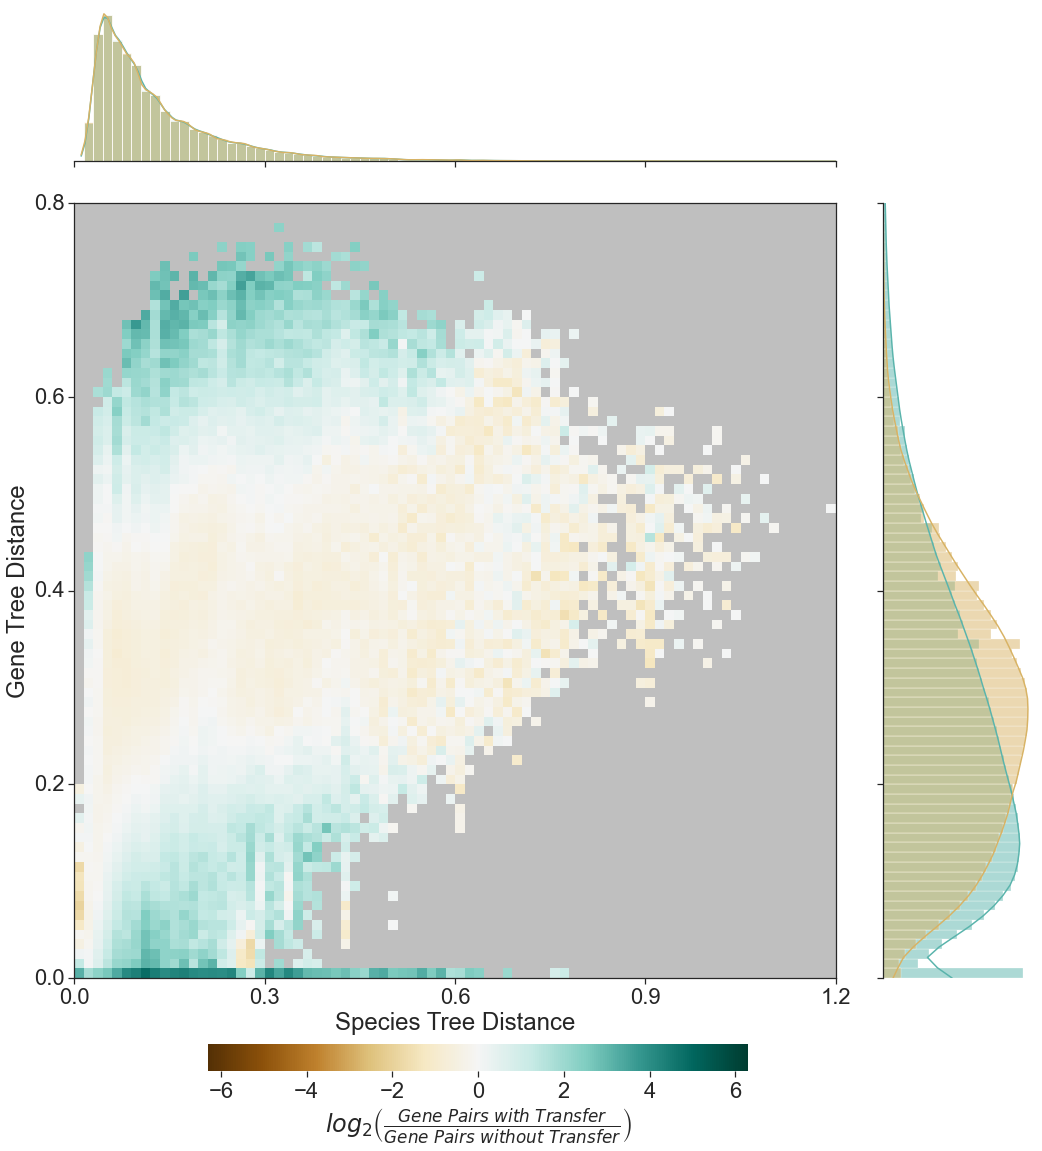

In [11]:
# For joint plot, need to calculate the ratio_fixed_sp between transfers and non-transfers.
sampled_pairs_fixed_distance = pd.concat([sampled_transfers_sp, sampled_reference_sp]).reset_index()

histogram_w_transfers_sp  = np.histogram2d(x = sampled_pairs_fixed_distance.loc[(sampled_pairs_fixed_distance["transfer"] == 1), "distance"],
                                           y = sampled_pairs_fixed_distance.loc[(sampled_pairs_fixed_distance["transfer"] == 1), "gene_distance"],
                                           bins = bin_number,
                                           range = [[min_distance, max_distance], [min_gene_distance, max_gene_distance]])
histogram_wo_transfers_sp = np.histogram2d(x = sampled_pairs_fixed_distance.loc[(sampled_pairs_fixed_distance["transfer"] == 0), "distance"],
                                           y = sampled_pairs_fixed_distance.loc[(sampled_pairs_fixed_distance["transfer"] == 0), "gene_distance"],
                                           bins = bin_number,
                                           range = [[min_distance, max_distance], [min_gene_distance, max_gene_distance]])
histogram_w_transfers_sp[0][histogram_w_transfers_sp[0] < 10] = np.nan
histogram_wo_transfers_sp[0][histogram_wo_transfers_sp[0] < 10] = np.nan

ratio_fixed_sp = np.log2(histogram_w_transfers_sp[0] / histogram_wo_transfers_sp[0])
ratio_fixed_sp = np.transpose(ratio_fixed_sp)
print(np.nanmin(ratio_fixed_sp), np.nanmax(ratio_fixed_sp))

sns.set(font_scale = 2)
sns.set_style("ticks")
figures, axes = plt.subplots(2, 2, figsize = (15, 15),
                             gridspec_kw = {"width_ratios": [5, 1], "height_ratios": [1, 5]})
cbar_ax = figures.add_axes([0.21, -0.01, 0.5, .025])

with sns.axes_style("white"):
    sns.histplot(data = sampled_pairs_fixed_distance, x = "distance", hue = "transfer", kde = True, legend = False,
                 alpha = 0.5, bins = bin_number, binrange = [min_distance, max_distance], ax = axes[0,0],
                 palette = ["#d8b365", "#5ab4ac"])


sns.heatmap(ratio_fixed_sp, annot = False, cmap = "BrBG", ax = axes[1, 0], center = 0, cbar_ax = cbar_ax,
            vmin = -6.3, vmax = 6.3,
            cbar_kws={'label': r'$log_2\left(\frac{Gene\ Pairs\ with\ Transfer}{Gene\ Pairs\ without\ Transfer}\right)$', 'orientation': 'horizontal'})

with sns.axes_style("white"):
    sns.histplot(data = sampled_pairs_fixed_distance, y = "gene_distance", hue = "transfer", kde = True, legend = False,
                 alpha = 0.5, bins = bin_number, binrange = [min_gene_distance, max_gene_distance], ax = axes[1,1],
                 palette = ["#d8b365", "#5ab4ac"])

axes[0,0].set(xlim = [min_distance, max_distance], xlabel = "", ylabel = "", yticks = [], yticklabels = [],
              xticks = np.array([0, 0.25*max_distance, 0.5*max_distance, 0.75*max_distance, max_distance]), xticklabels = [])
sns.despine(ax = axes[0,0], left = True, top = True, right = True, bottom = False)

axes[0,1].axis('off')

axes[1,0].invert_yaxis()
axes[1,0].set_xlabel("Species Tree Distance")
axes[1,0].set_xticks(np.array([0, 0.25*bin_number, 0.5*bin_number, 0.75*bin_number, bin_number]))
axes[1,0].set_xticklabels(["{:.1f}".format(x) for x in [0, 0.25*max_distance, 0.5*max_distance, 0.75*max_distance, max_distance]], rotation = 0)
axes[1,0].set_ylabel("Gene Tree Distance")
axes[1,0].set_yticks(np.array([0, 0.25*bin_number, 0.5*bin_number, 0.75*bin_number, bin_number]))
axes[1,0].set_yticklabels(["{:.1f}".format(x) for x in [0, 0.25*max_gene_distance, 0.5*max_gene_distance, 0.75*max_gene_distance, max_gene_distance]], rotation = 0)
axes[1,0].set_facecolor("#bfbfbf")
for _, spine in axes[1,0].spines.items():
    spine.set_visible(True)

axes[1,1].set(ylim = [min_gene_distance, max_gene_distance], xlabel = "", ylabel = "", xticks = [], xticklabels = [],
              yticks = np.array([0, 0.25*max_gene_distance, 0.5*max_gene_distance, 0.75*max_gene_distance, max_gene_distance]), yticklabels = [])
sns.despine(ax = axes[1,1], left = False, top = True, right = True, bottom = True)

figures.tight_layout(rect = [0, 0, 1, 1])

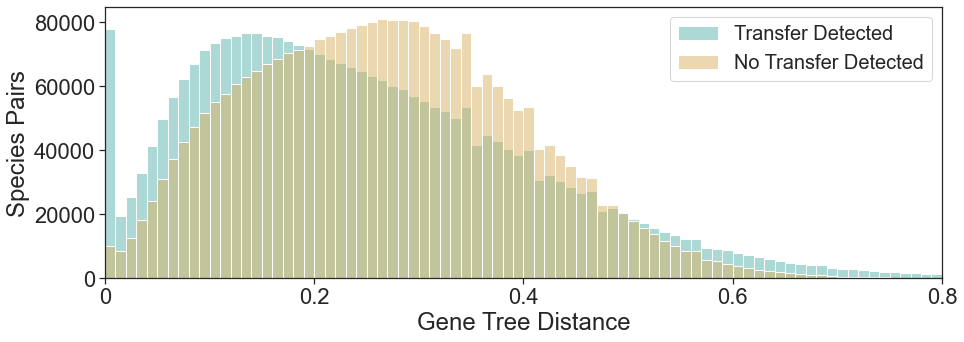

In [12]:
figures, axes = plt.subplots(1, 1, figsize = (15, 5))
sns.histplot(data = sampled_pairs_fixed_distance, x = "gene_distance", hue = "transfer", kde = False, axes = axes, edgecolor = None, legend = False, alpha = 0.5, bins = bin_number, binrange = [min_gene_distance, max_gene_distance], palette = ["#d8b365", "#5ab4ac"])
axes.set(xlabel = "Gene Tree Distance", xlim = [0, 0.8], xticks = [0, 0.2, 0.4, 0.6, 0.8], ylabel = "Species Pairs")
axes.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8"], rotation = 0)
plt.legend(labels = ["Transfer Detected", "No Transfer Detected"], prop = {'size': 20})

In [13]:
print(np.median(sampled_pairs_fixed_distance.loc[sampled_pairs_fixed_distance["transfer"] == 0, "gene_distance"]))
print(np.median(sampled_pairs_fixed_distance.loc[sampled_pairs_fixed_distance["transfer"] == 1, "gene_distance"]))
mannwhitneyu(sampled_pairs_fixed_distance.loc[sampled_pairs_fixed_distance["transfer"] == 0, "gene_distance"], sampled_pairs_fixed_distance.loc[sampled_pairs_fixed_distance["transfer"] == 1, "gene_distance"], alternative = "greater")

0.263
0.225


MannwhitneyuResult(statistic=4530367291996.0, pvalue=0.0)

### Fixing gene distance distribution to see what happens with species distance distribution.

In [14]:
ref_bins = np.linspace(min_gene_distance, max_gene_distance, bin_number + 1)

sampled_reference_gn = pd.DataFrame()
sampled_transfers_gn = pd.DataFrame()

for i in range(1, len(ref_bins)):
    
    sel_transfers_within_dist = pairs_w_transfers.loc[(pairs_w_transfers["gene_distance"] > ref_bins[i-1]) & (pairs_w_transfers["gene_distance"] <= ref_bins[i]), :] 
    sel_reference_within_dist = pairs_wo_transfers.loc[(pairs_wo_transfers["gene_distance"] > ref_bins[i-1]) & (pairs_wo_transfers["gene_distance"] <= ref_bins[i]), :]
    
    # If there are more gene pairs with transfers observed in this gene distance bin, subsampling them to match the number of gene pairs
    # without transfers and vice versa.
    if len(sel_transfers_within_dist) < len(sel_reference_within_dist):
        
        reference_to_add = sel_reference_within_dist.iloc[np.random.choice(len(sel_reference_within_dist), len(sel_transfers_within_dist), replace = False)]
        sampled_reference_gn = pd.concat([sampled_reference_gn, reference_to_add])    
        sampled_transfers_gn = pd.concat([sampled_transfers_gn, sel_transfers_within_dist])
    
    else:
        
        transfers_to_add = sel_transfers_within_dist.iloc[np.random.choice(len(sel_transfers_within_dist), len(sel_reference_within_dist), replace = False)]
        sampled_transfers_gn = pd.concat([sampled_transfers_gn, transfers_to_add])
        sampled_reference_gn = pd.concat([sampled_reference_gn, sel_reference_within_dist])
        
sampled_reference_gn["type"] = "No Transfer Detected"
sampled_transfers_gn["type"] = "Transfer Detected"

-4.918863237274595 5.220048480868149


/Users/mdmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


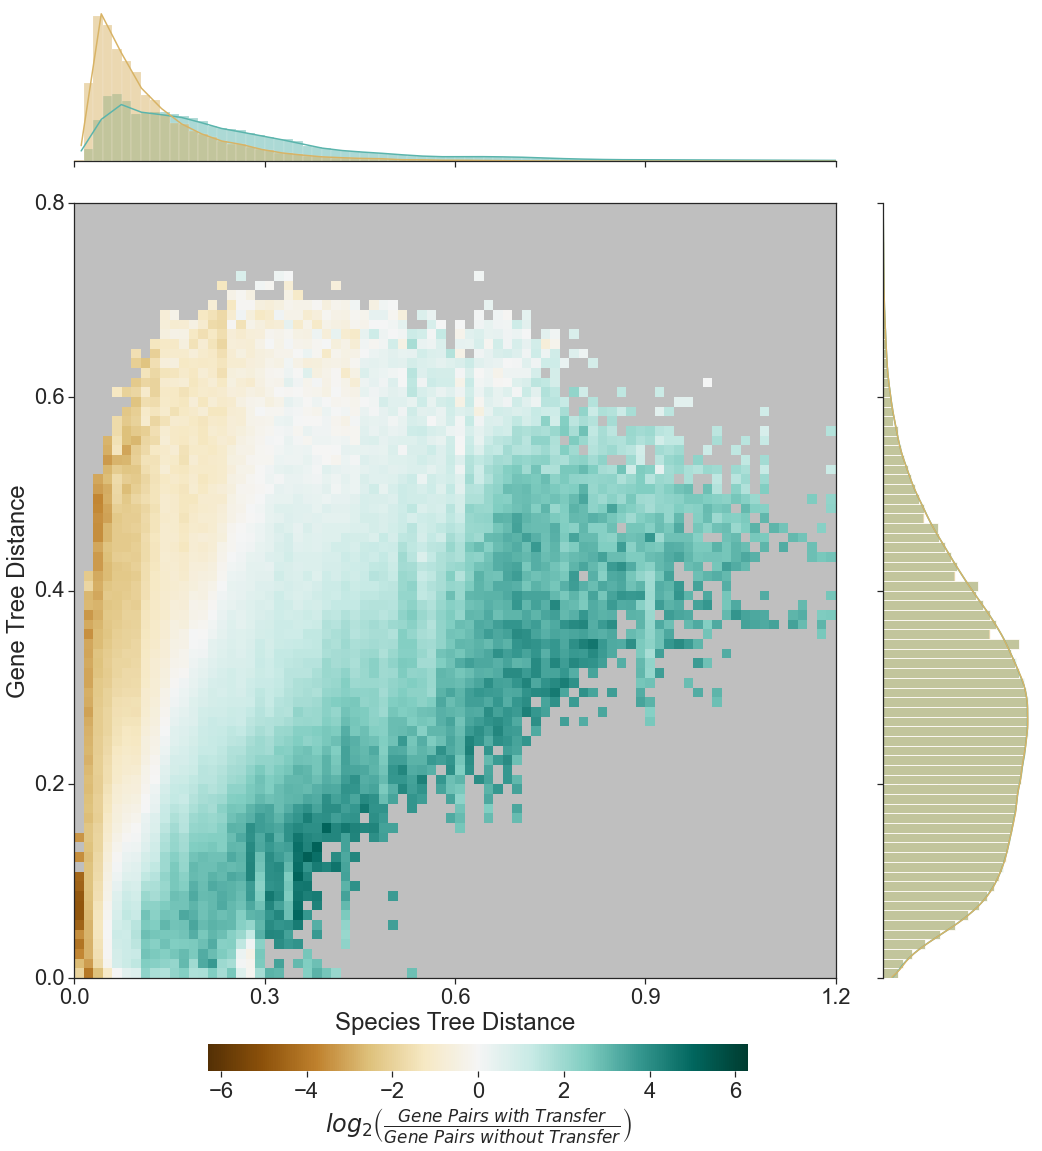

In [15]:
# For joint plot, need to calculate the ratio_fixed_gn between transfers and non-transfers.
sampled_pairs_fixed_gene_dist = pd.concat([sampled_reference_gn, sampled_transfers_gn]).reset_index()

histogram_w_transfers_gn  = np.histogram2d(x = sampled_pairs_fixed_gene_dist.loc[(sampled_pairs_fixed_gene_dist["transfer"] == 1), "distance"],
                                           y = sampled_pairs_fixed_gene_dist.loc[(sampled_pairs_fixed_gene_dist["transfer"] == 1), "gene_distance"],
                                           bins = bin_number,
                                           range = [[min_distance, max_distance], [min_gene_distance, max_gene_distance]])
histogram_wo_transfers_gn = np.histogram2d(x = sampled_pairs_fixed_gene_dist.loc[(sampled_pairs_fixed_gene_dist["transfer"] == 0), "distance"],
                                           y = sampled_pairs_fixed_gene_dist.loc[(sampled_pairs_fixed_gene_dist["transfer"] == 0), "gene_distance"],
                                           bins = bin_number,
                                           range = [[min_distance, max_distance], [min_gene_distance, max_gene_distance]])
histogram_w_transfers_gn[0][histogram_w_transfers_gn[0] < 10] = np.nan
histogram_wo_transfers_gn[0][histogram_wo_transfers_gn[0] < 10] = np.nan

ratio_fixed_gn = np.log2(histogram_w_transfers_gn[0] / histogram_wo_transfers_gn[0])
ratio_fixed_gn = np.transpose(ratio_fixed_gn)
print(np.nanmin(ratio_fixed_gn), np.nanmax(ratio_fixed_gn))

sns.set(font_scale = 2)
sns.set_style("ticks")
figures, axes = plt.subplots(2, 2, figsize = (15, 15),
                             gridspec_kw = {"width_ratios": [5, 1], "height_ratios": [1, 5]})
cbar_ax = figures.add_axes([0.21, -0.01, 0.5, .025])

with sns.axes_style("white"):
    sns.histplot(data = sampled_pairs_fixed_gene_dist, x = "distance", hue = "transfer", kde = True, legend = False,
                 alpha = 0.5, bins = bin_number, binrange = [min_distance, max_distance], ax = axes[0,0],
                 palette = ["#d8b365", "#5ab4ac"])


sns.heatmap(ratio_fixed_gn, annot = False, cmap = "BrBG", ax = axes[1, 0], center = 0, cbar_ax = cbar_ax,
            vmin = -6.3, vmax = 6.3,
            cbar_kws={'label': r'$log_2\left(\frac{Gene\ Pairs\ with\ Transfer}{Gene\ Pairs\ without\ Transfer}\right)$', 'orientation': 'horizontal'})

with sns.axes_style("white"):
    sns.histplot(data = sampled_pairs_fixed_gene_dist, y = "gene_distance", hue = "transfer", kde = True, legend = False,
                 alpha = 0.5, bins = bin_number, binrange = [min_gene_distance, max_gene_distance], ax = axes[1,1],
                 palette = ["#d8b365", "#5ab4ac"])

axes[0,0].set(xlim = [min_distance, max_distance], xlabel = "", ylabel = "", yticks = [], yticklabels = [],
              xticks = np.array([0, 0.25*max_distance, 0.5*max_distance, 0.75*max_distance, max_distance]), xticklabels = [])
sns.despine(ax = axes[0,0], left = True, top = True, right = True, bottom = False)

axes[0,1].axis('off')

axes[1,0].invert_yaxis()
axes[1,0].set_xlabel("Species Tree Distance")
axes[1,0].set_xticks(np.array([0, 0.25*bin_number, 0.5*bin_number, 0.75*bin_number, bin_number]))
axes[1,0].set_xticklabels(["{:.1f}".format(x) for x in [0, 0.25*max_distance, 0.5*max_distance, 0.75*max_distance, max_distance]], rotation = 0)
axes[1,0].set_ylabel("Gene Tree Distance")
axes[1,0].set_yticks(np.array([0, 0.25*bin_number, 0.5*bin_number, 0.75*bin_number, bin_number]))
axes[1,0].set_yticklabels(["{:.1f}".format(x) for x in [0, 0.25*max_gene_distance, 0.5*max_gene_distance, 0.75*max_gene_distance, max_gene_distance]], rotation = 0)
axes[1,0].set_facecolor("#bfbfbf")
for _, spine in axes[1,0].spines.items():
    spine.set_visible(True)

axes[1,1].set(ylim = [min_gene_distance, max_gene_distance], xlabel = "", ylabel = "", xticks = [], xticklabels = [],
              yticks = np.array([0, 0.25*max_gene_distance, 0.5*max_gene_distance, 0.75*max_gene_distance, max_gene_distance]), yticklabels = [])
sns.despine(ax = axes[1,1], left = False, top = True, right = True, bottom = True)

figures.tight_layout(rect = [0, 0, 1, 1])

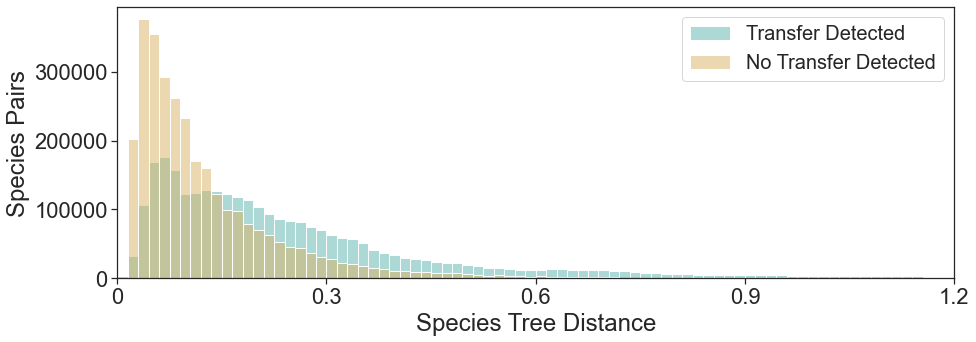

In [16]:
figures, axes = plt.subplots(1, 1, figsize = (15, 5))
sns.histplot(data = sampled_pairs_fixed_gene_dist, x = "distance", hue = "transfer", kde = False, axes = axes, legend = False, alpha = 0.5, bins = bin_number, binrange = [min_distance, max_distance], palette = ["#d8b365", "#5ab4ac"])
axes.set(xlabel = "Species Tree Distance", xlim = [0, 0.8], xticks = [0, 0.3, 0.6, 0.9, 1.2], ylabel = "Species Pairs")
axes.set_xticklabels(["0", "0.3", "0.6", "0.9", "1.2"], rotation = 0)
plt.legend(labels = ["Transfer Detected", "No Transfer Detected"], prop = {'size': 20})

In [18]:
print(np.nanmedian(sampled_pairs_fixed_gene_dist.loc[sampled_pairs_fixed_gene_dist["transfer"] == 0, "distance"]))
print(np.nanmedian(sampled_pairs_fixed_gene_dist.loc[sampled_pairs_fixed_gene_dist["transfer"] == 1, "distance"]))
mannwhitneyu(sampled_pairs_fixed_gene_dist.loc[sampled_pairs_fixed_gene_dist["transfer"] == 0, "distance"].dropna(), sampled_pairs_fixed_gene_dist.loc[sampled_pairs_fixed_gene_dist["transfer"] == 1, "distance"].dropna(), alternative = "less")

0.0916
0.1981


MannwhitneyuResult(statistic=2524082526971.5, pvalue=0.0)

# Comparing the ubiquity in the pangenome

In [19]:
# Uploading table containing data on how many members of the species contain indicated gene.
pangenome_presence_table = pd.read_csv("gene_ubiquity_within_pangenomes.tsv", sep = "\t")
pangenome_presence_table

speci_cluster                         representative_95  \
0            specI_v3_Cluster1   100053.SAMN02947772.GCA_002009845_00001   
1            specI_v3_Cluster1   100053.SAMN02947772.GCA_002009845_00002   
2            specI_v3_Cluster1   100053.SAMN02947772.GCA_002009845_00003   
3            specI_v3_Cluster1   100053.SAMN02947772.GCA_002009845_00004   
4            specI_v3_Cluster1   100053.SAMN02947772.GCA_002009845_00008   
...                        ...                                       ...   
45453724  specI_v3_Cluster9999  1805475.SAMEA4534506.GCA_900117315_04188   
45453725  specI_v3_Cluster9999  1805475.SAMEA4534506.GCA_900117315_04189   
45453726  specI_v3_Cluster9999  1805475.SAMEA4534506.GCA_900117315_04190   
45453727  specI_v3_Cluster9999  1805475.SAMEA4534506.GCA_900117315_04191   
45453728  specI_v3_Cluster9999  1805475.SAMEA4534506.GCA_900117315_04192   

          genomes_present  genomes_total  percentage  
0                       2              2       100.0  
1                       1              2        50.0  
2                       1              2        50.0  
3                       2              2       100.0  
4                       2              2       100.0  
...                   ...            ...         ...  
45453724                1              1       100.0  
45453725                1              1       100.0  
45453726                1              1       100.0  
45453727                1              1       100.0  
45453728                1              1       100.0  

[45453729 rows x 5 columns]

In [20]:
# Only considering specI clusters that contain at least ten different genomes for the analysis.
pangenome_presence_at_least_ten = pangenome_presence_table.loc[pangenome_presence_table["genomes_total"] >= 10, :]
mapping_genome_to_presence = pangenome_presence_at_least_ten["percentage"]
mapping_genome_to_presence.index = pangenome_presence_at_least_ten["representative_95"]

In [21]:
# Integrating information on pangenome ubiquity in gene pairs with and without transfers.
selected_pairs_w_presence = selected_pairs.copy()
selected_pairs_w_presence["pangenome_1"] = (selected_pairs_w_presence["genome_1"] + "." + selected_pairs_w_presence["gene_1"]).map(mapping_genome_to_presence)
selected_pairs_w_presence["pangenome_2"] = (selected_pairs_w_presence["genome_2"] + "." + selected_pairs_w_presence["gene_2"]).map(mapping_genome_to_presence)
selected_pairs_w_presence

family_id   node_id  transfer  \
9386446   1286329.SAMN01894008.GCA_000397225_01698  d90r0thw         1   
34465617   1121869.SAMN03084138.SAMN03084138_00921  t3y589tt         1   
17670889  1423744.SAMD00000454.GCA_001311465_00199  78mxpz6y         1   
51160309  1240350.SAMN01840335.GCA_000411615_03067  gr7x1d8i         1   
68256564    67263.SAMN02645525.GCA_000720255_02258  w6wrtwo6         1   
...                                            ...       ...       ...   
8222944        573.SAMEA3531565.SAMEA3531565_03722  9wyscic3         1   
8222947        573.SAMEA3531565.SAMEA3531565_03722  9wyscic3         1   
8222945        573.SAMEA3531565.SAMEA3531565_03722  9wyscic3         1   
8222965        573.SAMEA3531565.SAMEA3531565_03722  9wyscic3         1   
8222963        573.SAMEA3531565.SAMEA3531565_03722  9wyscic3         1   

              speci_1              genome_1               gene_1  \
9386446   Cluster3402   932213.SAMN02471700        SPM24T3_17395   
34465617  Cluster3766   868280.SAMN02597456  GCA_000565325_03386   
17670889  Cluster2490  1123500.SAMN02440571  GCA_000420365_00739   
51160309   Cluster118    50340.SAMN03100370           PF66_02416   
68256564  Cluster1447   285473.SAMN04595356          A4G23_00614   
...               ...                   ...                  ...   
8222944     Cluster50      648.SAMN03778994          ACH48_11770   
8222947     Cluster50      648.SAMN03778994          ACH48_11770   
8222945     Cluster50      648.SAMN03778994          ACH48_11770   
8222965    Cluster459   180282.SAMN02863025           GY14_29490   
8222963    Cluster459   180282.SAMN02863025           GY14_29490   

               speci_2              genome_2               gene_2  distance  \
9386446   Cluster11646   634436.SAMN05216361    SAMN05216361_2589    0.8301   
34465617     Cluster37   945550.SAMN02952919       VISI1226_01045    0.4090   
17670889   Cluster8258  1423792.SAMN02369469        FD09_GL002111    1.0914   
51160309   Cluster4513   653930.SAMN04487855    SAMN04487855_3102    0.4994   
68256564    Cluster679   285535.SAMN02645250  GCA_000718165_06258    0.3404   
...                ...                   ...                  ...       ...   
8222944      Cluster80  1354260.SAMD00046898  GCA_001598855_05225    0.6846   
8222947      Cluster56  1324960.SAMN03322533           K931_16544    0.0532   
8222945      Cluster62    61648.SAMN06458494          B2M27_20310    0.6468   
8222965     Cluster496  1572758.SAMN03195666            PO78_3013    1.0970   
8222963    Cluster5080   223789.SAMEA3305040         THICB1_10178    0.7420   

          gene_distance  seq_identity  seq_coverage  pangenome_1  pangenome_2  
9386446             0.8         74.65         90.59          NaN          NaN  
34465617            0.8         74.58         77.73          NaN          NaN  
17670889            0.8         71.04         81.33          NaN          NaN  
51160309            0.8         64.02         79.52          NaN          NaN  
68256564            0.8         71.74         75.71          NaN          NaN  
...                 ...           ...           ...          ...          ...  
8222944             0.0        100.00         85.91        22.22        36.36  
8222947             0.0        100.00         85.91        22.22         3.33  
8222945             0.0        100.00         85.91        22.22          NaN  
8222965             0.0        100.00         85.91         5.56          NaN  
8222963             0.0        100.00         85.91         5.56          NaN  

[17144156 rows x 15 columns]

In [22]:
# Removing rows where both specI clusters have less than ten genomes present.
print(selected_pairs_w_presence.shape)
selected_pairs_w_presence = selected_pairs_w_presence.dropna(subset = ["pangenome_1", "pangenome_2"])
print(selected_pairs_w_presence.shape)

(17144156, 15)
(327855, 15)


In [23]:
# For each species pair, we have two ubiquity values. For the purposes of the analysis, we will consider the species with higher gene
# ubiquity to be the donor of the transferred gene and the species with lower gene ubiquity to be the recipient of the transferred gene.
selected_pairs_w_presence["minimum_pangenome"] = np.minimum(selected_pairs_w_presence["pangenome_1"], selected_pairs_w_presence["pangenome_2"])
selected_pairs_w_presence["maximum_pangenome"] = np.maximum(selected_pairs_w_presence["pangenome_1"], selected_pairs_w_presence["pangenome_2"])
selected_pairs_w_presence["average_pangenome"] = (selected_pairs_w_presence["pangenome_1"] + selected_pairs_w_presence["pangenome_2"])/2
selected_pairs_w_presence

/Users/mdmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mdmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/mdmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

family_id   node_id  transfer  \
44781907       1263831.SAMN03081510.F543_10790  gl1jnbcx         1   
18612305       190893.SAMN03857122.ADU60_18155  vt6dcjm0         1   
15805175    28151.SAMEA103936875.SPRA44_300002  21u24bsu         1   
9529136      1313.SAMEA2238776.ERS367588_00991  cftkoo6t         1   
77856648        1265647.SAMEA2272755.SA39_4176  j1o3f00m         1   
...                                        ...       ...       ...   
13331105  343.SAMN04279080.GCA_001461905_02477  fgv6nqg1         1   
52190607     1834168.SAMN04634064.A5865_003649  2lzs7zb8         1   
8222980    573.SAMEA3531565.SAMEA3531565_03722  9wyscic3         1   
8222944    573.SAMEA3531565.SAMEA3531565_03722  9wyscic3         1   
8222947    573.SAMEA3531565.SAMEA3531565_03722  9wyscic3         1   

              speci_1              genome_1              gene_1      speci_2  \
44781907  Cluster2035  1399771.SAMN02388246         HPS41_07995   Cluster938   
18612305    Cluster29  1298599.SAMD00000560       JCM18904_2367  Cluster1749   
15805175    Cluster95   550694.SAMN02596695          ERIG_01875  Cluster1087   
9529136   Cluster1591  1073373.SAMN01162043    HMPREF1196_01462   Cluster900   
77856648  Cluster1094  1454377.SAMN03010446           AW19_1042    Cluster99   
...               ...                   ...                 ...          ...   
13331105  Cluster1058   237610.SAMN05216279  SAMN05216279_12538   Cluster201   
52190607   Cluster567  1715053.SAMN04498581    HMPREF2574_03675   Cluster900   
8222980     Cluster50      648.SAMN03778994         ACH48_11770    Cluster86   
8222944     Cluster50      648.SAMN03778994         ACH48_11770    Cluster80   
8222947     Cluster50      648.SAMN03778994         ACH48_11770    Cluster56   

                      genome_2               gene_2  distance  gene_distance  \
44781907   656913.SAMN02595334           HIAG_00431    0.3318            0.8   
18612305   388396.SAMN02603627         VFMJ11_A0295    0.2239            0.8   
15805175     28152.SAMEA859891      ERS008460_03516    0.3152            0.8   
9529136     59310.SAMN02786859           FD61_01010    0.3192            0.8   
77856648    41520.SAMN02367807  GCA_002034545_02064    0.3218            0.8   
...                        ...                  ...       ...            ...   
13331105      287.SAMEA2592368  GCA_000751715_06820    0.2107            0.0   
52190607    53354.SAMN03353742           UG96_03760    0.3284            0.0   
8222980   1134455.SAMN02471877  GCA_000252915_00307    0.6947            0.0   
8222944   1354260.SAMD00046898  GCA_001598855_05225    0.6846            0.0   
8222947   1324960.SAMN03322533           K931_16544    0.0532            0.0   

          seq_identity  seq_coverage  pangenome_1  pangenome_2  \
44781907         73.58         83.62        96.67        99.25   
18612305         71.05         97.11        72.73        14.29   
15805175         71.35         76.48         0.14        11.76   
9529136          65.61         98.44        71.88        19.23   
77856648         71.62         94.24        38.46        98.90   
...                ...           ...          ...          ...   
13331105        100.00         92.46         8.33         0.09   
52190607        100.00         97.47        20.00        23.08   
8222980         100.00         85.91        22.22        37.38   
8222944         100.00         85.91        22.22        36.36   
8222947         100.00         85.91        22.22         3.33   

          minimum_pangenome  maximum_pangenome  average_pangenome  
44781907              96.67              99.25             97.960  
18612305              14.29              72.73             43.510  
15805175               0.14              11.76              5.950  
9529136               19.23              71.88             45.555  
77856648              38.46              98.90             68.680  
...                     ...                ...                ...  
13331

In [24]:
selected_pairs_w_presence["category"] = "shell"
selected_pairs_w_presence.loc[selected_pairs_w_presence["minimum_pangenome"] >= 90, "category"] = "core"
selected_pairs_w_presence.loc[selected_pairs_w_presence["minimum_pangenome"] <= 15, "category"] = "cloud"
selected_pairs_w_presence["category"].value_counts()

/Users/mdmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mdmit/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


cloud    205844
shell     63129
core      58882
Name: category, dtype: int64

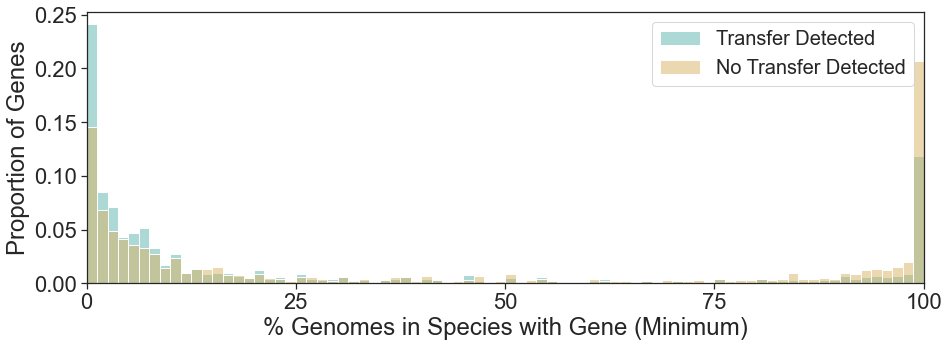

In [25]:
figures, axes = plt.subplots(1, 1, figsize = (15, 5))
sns.histplot(data = selected_pairs_w_presence.reset_index(), x = "minimum_pangenome", hue = "transfer", stat = "proportion", common_norm = False, axes = axes, legend = False, alpha = 0.5, bins = bin_number, binrange = [0, 100], palette = ["#d8b365", "#5ab4ac"])
axes.set(xlabel = "% Genomes in Species with Gene (Minimum)", xlim = [0, 100], xticks = [0, 25, 50, 75, 100], ylabel = "Proportion of Genes")
plt.legend(labels = ["Transfer Detected", "No Transfer Detected"], prop = {'size': 20}, loc = 'upper right')

In [26]:
minimum_cloud_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] <= 15) & (selected_pairs_w_presence["transfer"] == 1), :])
minimum_cloud_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] <= 15) & (selected_pairs_w_presence["transfer"] == 0), :])
minimum_not_cloud_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] > 15) & (selected_pairs_w_presence["transfer"] == 1), :])
minimum_not_cloud_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] > 15) & (selected_pairs_w_presence["transfer"] == 0), :])
fisher_exact([[minimum_cloud_w_transfer, minimum_not_cloud_w_transfer], [minimum_cloud_wo_transfer, minimum_not_cloud_wo_transfer]])

(2.0690157953148534, 0.0)

In [27]:
minimum_extended_core_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] >= 90) & (selected_pairs_w_presence["transfer"] == 1), :])
minimum_extended_core_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] >= 90) & (selected_pairs_w_presence["transfer"] == 0), :])
minimum_not_extended_core_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] < 90) & (selected_pairs_w_presence["transfer"] == 1), :])
minimum_not_extended_core_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] < 90) & (selected_pairs_w_presence["transfer"] == 0), :])
fisher_exact([[minimum_extended_core_w_transfer, minimum_not_extended_core_w_transfer], [minimum_extended_core_wo_transfer, minimum_not_extended_core_wo_transfer]])

(0.46114645615685, 0.0)

In [28]:
minimum_shell_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] < 90) & (selected_pairs_w_presence["minimum_pangenome"] < 15) & (selected_pairs_w_presence["transfer"] == 1), :])
minimum_shell_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["minimum_pangenome"] < 90) & (selected_pairs_w_presence["minimum_pangenome"] < 15) & (selected_pairs_w_presence["transfer"] == 0), :])
minimum_not_shell_w_transfer = len(selected_pairs_w_presence.loc[((selected_pairs_w_presence["minimum_pangenome"] >= 90) | (selected_pairs_w_presence["minimum_pangenome"] <= 15)) & (selected_pairs_w_presence["transfer"] == 1), :])
minimum_not_shell_wo_transfer = len(selected_pairs_w_presence.loc[((selected_pairs_w_presence["minimum_pangenome"] >= 90) | (selected_pairs_w_presence["minimum_pangenome"] <= 15)) & (selected_pairs_w_presence["transfer"] == 0), :])
fisher_exact([[minimum_shell_w_transfer, minimum_not_shell_w_transfer], [minimum_shell_wo_transfer, minimum_not_shell_wo_transfer]])

(1.3010245968948668, 2.826221482814834e-163)

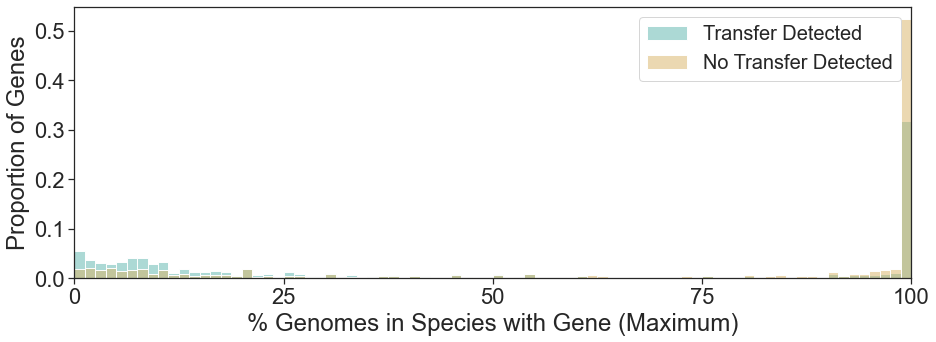

In [29]:
figures, axes = plt.subplots(1, 1, figsize = (15, 5))
sns.histplot(data = selected_pairs_w_presence.reset_index(), x = "maximum_pangenome", hue = "transfer", stat = "proportion", common_norm = False, axes = axes, legend = False, alpha = 0.5, bins = bin_number, binrange = [0, 100], palette = ["#d8b365", "#5ab4ac"])
axes.set(xlabel = "% Genomes in Species with Gene (Maximum)", xlim = [0, 100], xticks = [0, 25, 50, 75, 100], ylabel = "Proportion of Genes")
plt.legend(labels = ["Transfer Detected", "No Transfer Detected"], prop = {'size': 20}, loc = 'upper right')

In [30]:
maximum_cloud_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] <= 15) & (selected_pairs_w_presence["transfer"] == 1), :])
maximum_cloud_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] <= 15) & (selected_pairs_w_presence["transfer"] == 0), :])
maximum_not_cloud_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] > 15) & (selected_pairs_w_presence["transfer"] == 1), :])
maximum_not_cloud_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] > 15) & (selected_pairs_w_presence["transfer"] == 0), :])
fisher_exact([[maximum_cloud_w_transfer, maximum_not_cloud_w_transfer], [maximum_cloud_wo_transfer, maximum_not_cloud_wo_transfer]])

(2.8669027235729474, 0.0)

In [31]:
maximum_extended_core_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] >= 90) & (selected_pairs_w_presence["transfer"] == 1), :])
maximum_extended_core_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] >= 90) & (selected_pairs_w_presence["transfer"] == 0), :])
maximum_not_extended_core_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] < 90) & (selected_pairs_w_presence["transfer"] == 1), :])
maximum_not_extended_core_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] < 90) & (selected_pairs_w_presence["transfer"] == 0), :])
fisher_exact([[maximum_extended_core_w_transfer, maximum_not_extended_core_w_transfer], [maximum_extended_core_wo_transfer, maximum_not_extended_core_wo_transfer]])

(0.36916420504544245, 0.0)

In [32]:
maximum_shell_w_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] < 90) & (selected_pairs_w_presence["maximum_pangenome"] < 15) & (selected_pairs_w_presence["transfer"] == 1), :])
maximum_shell_wo_transfer = len(selected_pairs_w_presence.loc[(selected_pairs_w_presence["maximum_pangenome"] < 90) & (selected_pairs_w_presence["maximum_pangenome"] < 15) & (selected_pairs_w_presence["transfer"] == 0), :])
maximum_not_shell_w_transfer = len(selected_pairs_w_presence.loc[((selected_pairs_w_presence["maximum_pangenome"] >= 90) | (selected_pairs_w_presence["maximum_pangenome"] <= 15)) & (selected_pairs_w_presence["transfer"] == 1), :])
maximum_not_shell_wo_transfer = len(selected_pairs_w_presence.loc[((selected_pairs_w_presence["maximum_pangenome"] >= 90) | (selected_pairs_w_presence["maximum_pangenome"] <= 15)) & (selected_pairs_w_presence["transfer"] == 0), :])
fisher_exact([[maximum_shell_w_transfer, maximum_not_shell_w_transfer], [maximum_shell_wo_transfer, maximum_not_shell_wo_transfer]])

(2.2894300290628817, 0.0)

# Ubiquity in pangenome across different degrees of gene divergence 

[Text(0.5, 0, 'Gene Distance'),
 Text(0, 0.5, 'Proportion of Genes'),
 (-0.01, 0.71),
 (0.0, 100.0)]

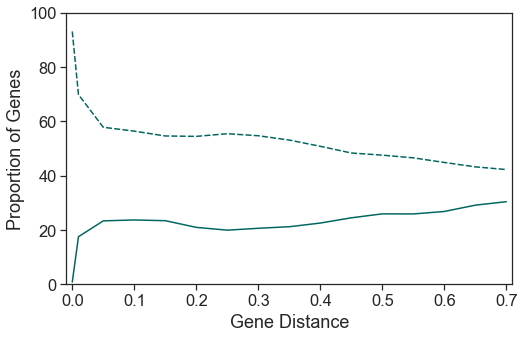

In [33]:
overview_fractions = {"distance": [], "category": [], "fraction": []}
distance_br = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
for i in range(len(distance_br)-1):
    pairs_w_presence_within_dist = selected_pairs_w_presence.loc[(selected_pairs_w_presence["gene_distance"] >= distance_br[i]) & (selected_pairs_w_presence["gene_distance"] < distance_br[i+1]), :]
    
    overview_fractions["distance"].extend([distance_br[i], distance_br[i]])
    overview_fractions["category"].append("core")
    overview_fractions["fraction"].append(100*sum(pairs_w_presence_within_dist["category"] == "core")/len(pairs_w_presence_within_dist))
    overview_fractions["category"].append("cloud")
    overview_fractions["fraction"].append(100*sum(pairs_w_presence_within_dist["category"] == "cloud")/len(pairs_w_presence_within_dist))

overview_fractions = pd.DataFrame(overview_fractions)

sns.set(font_scale = 1.5)
sns.set_style("ticks")
figures, axes = plt.subplots(1, 1, figsize = (8, 5), sharex = True, sharey = True)

sns.lineplot(x = overview_fractions["distance"], y = overview_fractions["fraction"], style = overview_fractions["category"], color = "#01665e", markers = False, ax = axes, legend = False)
axes.set(xlabel = "Gene Distance", ylabel = "Proportion of Genes", xlim = [-0.01, 0.71], ylim = [0, 100])

/Users/mdmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


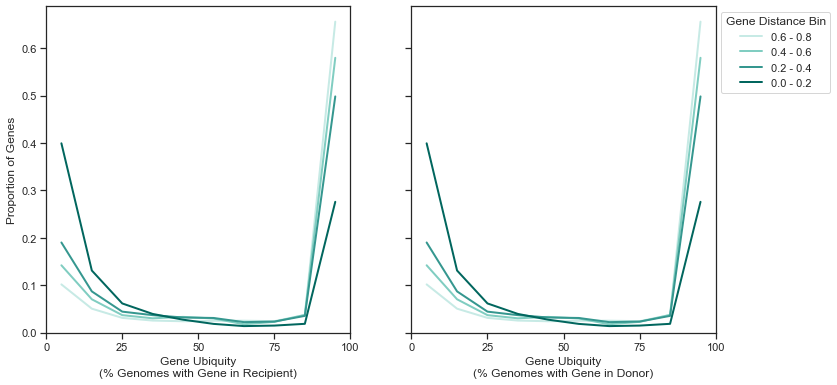

In [56]:
sns.set(font_scale = 1)
sns.set_style("ticks")
figures, axes = plt.subplots(1, 2, figsize = (12, 6), sharex = True, sharey = True)

transfer_pairs_within_gene_distance = selected_pairs_w_presence.loc[selected_pairs_w_presence["gene_distance"] < 0.8, :]
transfer_pairs_within_gene_distance["gene_distance_bin"] = ((5 * transfer_pairs_within_gene_distance["gene_distance"]) // 1) / 5
transfer_pairs_within_gene_distance = transfer_pairs_within_gene_distance.reset_index()

sns.histplot(x = transfer_pairs_within_gene_distance["maximum_pangenome"], hue = transfer_pairs_within_gene_distance["gene_distance_bin"], palette = ["#01665e", "#35978f", "#80cdc1", "#c7eae5"], stat = "proportion", fill = False, bins = 10, lw = 2, common_norm = False, element = "poly", ax = axes[0], legend = False)
sns.histplot(x = transfer_pairs_within_gene_distance["maximum_pangenome"], hue = transfer_pairs_within_gene_distance["gene_distance_bin"], palette = ["#01665e", "#35978f", "#80cdc1", "#c7eae5"], stat = "proportion", fill = False, bins = 10, lw = 2, common_norm = False, element = "poly", ax = axes[1])
axes[0].set(xlabel = "Gene Ubiquity\n(% Genomes with Gene in Recipient)", xlim = [0, 100], xticks = [0, 25, 50, 75, 100], ylabel = "Proportion of Genes")
axes[1].set(xlabel = "Gene Ubiquity\n(% Genomes with Gene in Donor)", xlim = [0, 100], xticks = [0, 25, 50, 75, 100])
axes[1].legend(title = "Gene Distance Bin", labels=['0.6 - 0.8', '0.4 - 0.6', '0.2 - 0.4', '0.0 - 0.2'])
sns.move_legend(axes[1], "upper left", bbox_to_anchor = (1, 1))